In [193]:
import torch
import torch.nn as nn

from tqdm import trange

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [220]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, masked=False):
        super().__init__()
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.d_head_t = torch.tensor(self.d_head)
        self.masked = masked
        
        assert(self.d_head * self.n_heads == self.d_model)
        
        self.qkv = nn.ModuleList([nn.ModuleList([nn.Linear(self.d_model, self.d_head, bias=False)]*3)]*self.n_heads)
        
        self.fc_out = nn.Linear(self.d_model, self.d_model, bias=False)
        
        
    def forward(self, q_in, k_in, v_in):
        self.mask = torch.ones((q_in.shape[0], k_in.shape[0]))
        if(self.masked):
            self.mask = torch.tril(self.mask)
            
        self_attention_out = torch.tensor([])
        for [q_linear, k_linear, v_linear] in self.qkv:
            Q = q_linear(q_in)
            K = k_linear(k_in)
            V = v_linear(v_in)
            
            mat_mul = (Q @ K.T).masked_fill(self.mask == 0, float("-inf"))
            scale = mat_mul/torch.sqrt(self.d_head_t)
            softmax = torch.nn.functional.softmax(scale, dim=None)
            scaled_dot_prod_attention = softmax @ V
            
            self_attention_out = torch.cat([self_attention_out, scaled_dot_prod_attention], dim=1)
                
        
        out = self.fc_out(self_attention_out)
        self.out = out
        return out
        

In [221]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout, ff_hidden_size):
        super().__init__()
        
        self.d_model = d_model
        self.n_heads = n_heads
        
        self.attention = SelfAttention(self.d_model, self.n_heads, False)
        self.norm1 = nn.LayerNorm(self.d_model)
        self.ff = nn.Sequential(
            nn.Linear(self.d_model, ff_hidden_size),
            nn.ReLU(),
            nn.Linear(ff_hidden_size, self.d_model)
        )
        self.norm2 = nn.LayerNorm(self.d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, block_in):
        # self attention
        sa = self.attention(block_in, block_in, block_in)
        
        # add & norm
        sa_res_norm = self.dropout(self.norm1(sa + block_in))
        
        # feed-forward
        ff = self.ff(sa_res_norm)
        
        # add & norm
        ff_res_norm = self.dropout(self.norm2(ff + sa_res_norm))
        
        self.out = ff_res_norm
        return ff_res_norm  

In [222]:
class Encoder(nn.Module):
    def __init__(self, d_model, n_stack, vocab_size, n_heads, dropout, ff_hidden_size, max_length):
        super().__init__()
            
        self.d_model = d_model
        self.n_stack = n_stack
        self.n_heads = n_heads
        self.vocab_size = vocab_size
        self.max_length = max_length
        
        self.seq_embedding = nn.Embedding(self.vocab_size, self.d_model)
        self.positional_embedding = nn.Embedding(self.max_length, self.d_model)
        
        self.encoder_blocks = nn.ModuleList(
            [
                EncoderBlock(self.d_model, self.n_heads, dropout, ff_hidden_size)
            ] * self.n_stack
        )
    
    def forward(self, x):        
        out = self.seq_embedding(x) + self.positional_embedding(torch.arange(0, x.shape[0]))
        
        for block in self.encoder_blocks:
            out = block(out)
            
        self.out = out
        return out

In [224]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout, ff_hidden_size):
        super().__init__()
        
        self.d_model = d_model
        self.n_heads = n_heads
        
        self.masked_attention = SelfAttention(self.d_model, self.n_heads, True)
        self.norm1 = nn.LayerNorm(self.d_model)
        
        self.attention = SelfAttention(self.d_model, self.n_heads, True)
        self.norm2 = nn.LayerNorm(self.d_model)
        
        self.ff = nn.Sequential(
            nn.Linear(self.d_model, ff_hidden_size),
            nn.ReLU(),
            nn.Linear(ff_hidden_size, self.d_model)
        )
        self.norm3 = nn.LayerNorm(self.d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, enc_out, block_in):
        # masked self attention
        msa = self.masked_attention(block_in, block_in, block_in)
        
        # add & norm
        msa_res_norm = self.dropout(self.norm1(msa + block_in))
        
        # self attention
        sa = self.attention(block_in, enc_out, enc_out)
        
        # add & norm
        sa_res_norm = self.dropout(self.norm2(sa + msa_res_norm))
        
        # feed-forward
        ff = self.ff(sa_res_norm)
        
        # add & norm
        ff_res_norm = self.dropout(self.norm3(ff + sa_res_norm))
        
        self.out = ff_res_norm
        return ff_res_norm  
        

In [225]:
class Decoder(nn.Module):
    def __init__(self, d_model, n_stack, vocab_size, n_heads, dropout, ff_hidden_size, max_length):
        super().__init__()
        self.d_model = d_model
        self.n_stack = n_stack
        self.n_heads = n_heads
        self.vocab_size = vocab_size
        self.max_length = max_length
        
        self.seq_embedding = nn.Embedding(self.vocab_size, self.d_model)
        self.positional_embedding = nn.Embedding(self.max_length, self.d_model)
        
        self.decoder_blocks = nn.ModuleList(
            [
                DecoderBlock(self.d_model, self.n_heads, dropout, ff_hidden_size)
            ] * self.n_stack
        )
        
        self.fc_out = nn.Linear(d_model, vocab_size)
    
    def forward(self, src, x):
        out = self.seq_embedding(x) + self.positional_embedding(torch.arange(0, x.shape[0]))
        
        for block in self.decoder_blocks:
            out = block(src, out)
            
        out = self.fc_out(out)
        
        out = out.softmax(dim=1)
        self.out = out
        return out

In [226]:
class Transformer(nn.Module):
    def __init__(self, d_model, n_stack, vocab_size, n_heads, dropout, ff_hidden_size, max_length=512):
        super().__init__()      
        
        self.encoder = Encoder(d_model, n_stack, vocab_size, n_heads, dropout, ff_hidden_size, max_length)
        
        self.decoder = Decoder(d_model, n_stack, vocab_size, n_heads, dropout, ff_hidden_size, max_length)
        
    def forward(self, src, trg):
        enc_out = self.encoder(src) 
        
        out = self.decoder(enc_out, trg)
        
        self.out = out
        return out

In [227]:
raw_names = open("names.txt").read().split("\n")
names = [list(n) for n in raw_names]

In [228]:
open_token = "<o>"
close_token = "<c>"
vocab = sorted(set([open_token, close_token] + [ch for name in names for ch in name]))

ch_to_i = {ch:idx for (idx, ch) in enumerate(vocab)}
i_to_ch = {idx:ch for (idx, ch) in enumerate(vocab)}

encoded_names = [[ch_to_i[ch] for ch in name] for name in names]

In [229]:
d_model = 16
n_stack = 2
vocab_size = len(vocab)
n_heads = 4
dropout = 0.95
t = Transformer(d_model, n_stack, vocab_size, n_heads, dropout, d_model*4)

In [230]:
parameters = t.parameters()
print(f"{sum([p.nelement() for p in parameters])} parameters")

23132 parameters


In [231]:
enc_inputs = [torch.tensor(name) for name in encoded_names]
dec_inputs = [torch.tensor([ch_to_i[open_token]] + enc_name) for enc_name in encoded_names]
exp_out = [torch.tensor(enc_name + [ch_to_i[close_token]]) for enc_name in encoded_names]
exp_out = [torch.nn.functional.one_hot(i, vocab_size).float() for i in exp_out]

In [232]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adamax(t.parameters())

dataset_size = len(encoded_names)

In [233]:
with trange(10) as pbar:
    for it in pbar:
        batch_size = 64
        ix = torch.randint(0, dataset_size, (batch_size,))
        
        optimiser.zero_grad()
        
        loss = 0
        for idx in ix:
            out = t(enc_inputs[idx], dec_inputs[idx])
            loss += cross_entropy_loss(out, exp_out[idx])

        loss /= batch_size

        pbar.set_description(f"Loss: {loss.item():.4f}")

        loss.backward()

        optimiser.step()   

Loss: 3.3315: 100%|█████████████████████████████| 10/10 [00:03<00:00,  2.61it/s]


Text(0.5, 1.0, 'Activations')

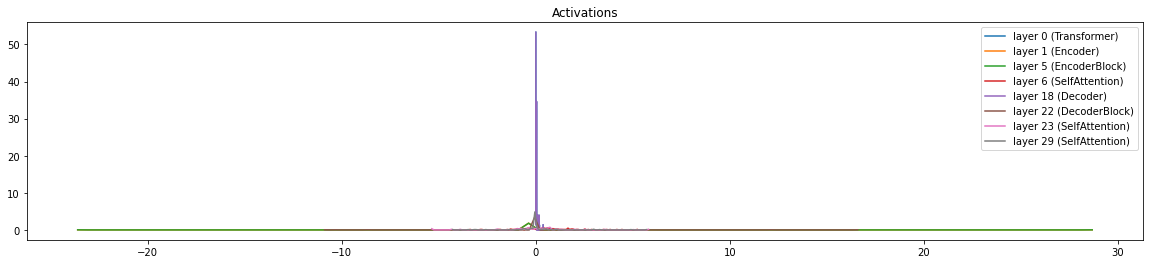

In [234]:
layers = t.modules()

plt.figure(figsize=(20,4))
legends = []
for (idx, layer) in enumerate(layers):
    if(hasattr(layer, "out")): 
        l = layer.out.detach()
        
        hy,hx = torch.histogram(l, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        
        legends.append(f'layer {idx} ({layer.__class__.__name__})')
    
plt.legend(legends)
plt.title("Activations")

Text(0.5, 1.0, 'Parameters')

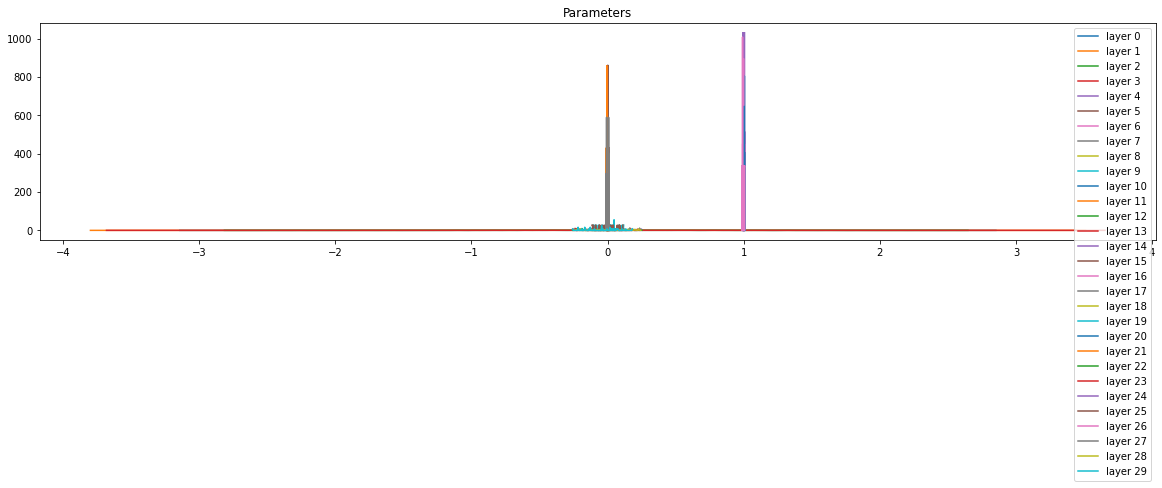

In [235]:
plt.figure(figsize=(20,4))
legends = []
for (idx, layer) in enumerate(t.parameters()):
    hy,hx = torch.histogram(layer, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())

    legends.append(f'layer {idx}')
    
plt.legend(legends)
plt.title("Parameters")

Text(0.5, 1.0, 'Activations')

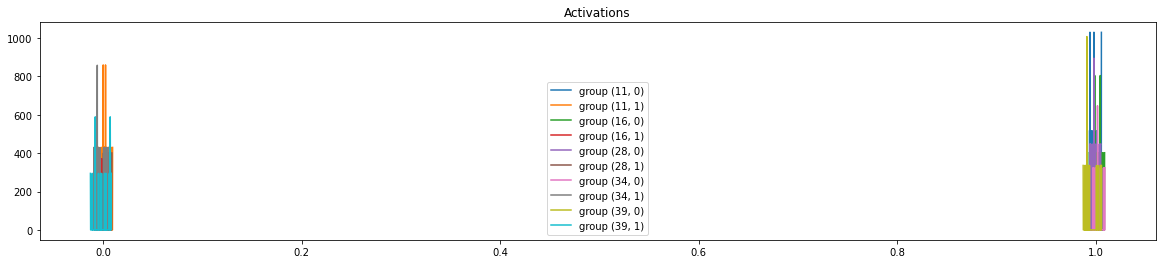

In [236]:
layers = t.modules()

plt.figure(figsize=(20,4))
legends = []
for (idx, layer) in enumerate(layers):
    if(isinstance(layer, nn.LayerNorm)):
        for (i, p) in enumerate(layer.parameters()):
            hy,hx = torch.histogram(p.data, density=True)
            legends.append(f'group {idx, i}')
            plt.plot(hx[:-1].detach(), hy.detach())
            
plt.legend(legends)
plt.title("Activations")

Text(0.5, 1.0, 'Activations')

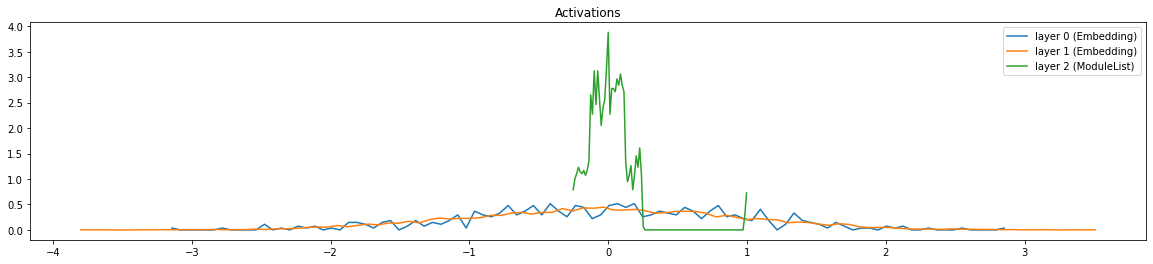

In [260]:
encoder = [t for t in t.modules() if isinstance(t, Encoder)][0]

plt.figure(figsize=(20,4))
legends = []
for (idx, layer) in enumerate(encoder.children()):
    ps = []
    for p in layer.parameters():
        ps += p.data.view(-1).tolist()
        
    ps = torch.tensor(ps)
    hy,hx = torch.histogram(ps, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())

    legends.append(f'layer {idx} ({layer.__class__.__name__})')
    
plt.legend(legends)
plt.title("Activations")